In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

from datetime import datetime


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from nlp_functions import text_feature_engineering, pos_lemmatizer, custom_lemmatize, lemmatize_text

In [3]:
fomc = pd.read_pickle('../data/fomc_data.pkl')
fomc.head(3)

minutes_paragraphs  \
1993-02-03  [[meeting, federal, open, market, committee, h...   
1993-03-23  [[meeting, federal, open, market, committee, h...   
1993-05-18  [[meeting, federal, open, market, committee, h...   

                                            paragraphs_length  \
1993-02-03  [12, 15, 24, 29, 12, 32, 37, 32, 14, 16, 82, 5...   
1993-03-23  [11, 13, 64, 23, 24, 28, 60, 51, 64, 56, 100, ...   
1993-05-18  [11, 26, 19, 25, 27, 62, 46, 54, 37, 89, 56, 6...   

                                                 minutes_text text_length  
1993-02-03  meeting federal open market committee hold off...        4437  
1993-03-23  meeting federal open market committee hold off...        2789  
1993-05-18  meeting federal open market committee hold off...        2354

In [4]:
fomcwordcloud = [word for minute in fomc['minutes_paragraphs'] for val in minute for word in val]

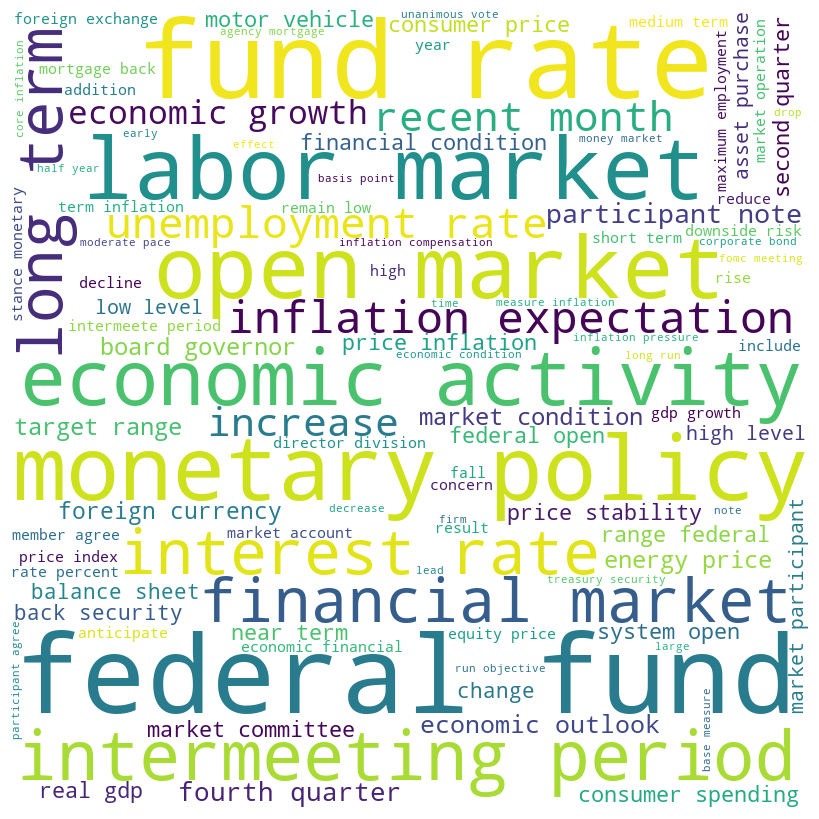

In [5]:
plt.figure(figsize=(8,8))
wordcloud = WordCloud(
    background_color="white",  # Set the background color
    colormap="viridis",  # Choose a colormap for the colors of the words
    width=800, height=800,  # Set the size of the word cloud canvas
    max_words=100,  # Limit the maximum number of words shown in the cloud
    contour_color='steelblue',  # Set the color for word cloud contour lines
    contour_width=3,  # Set the width of contour lines

).generate(','.join(fomcwordcloud)) # NB. 'join' method used to convert the documents list to text format
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../images/wordcloud_bigrams.png', dpi=600);

In [6]:
fomc_raw = pd.read_pickle('../data/fomc_raw_text.pkl')
fomc_raw.head()

fomc_text
date                                                         
1993-02-03  The Secretary reported that advices of the ele...
1993-03-23  At the start of the meeting, the subcommittee ...
1993-05-18  1. Attended portion of meeting relating to a r...
1993-07-07  Mr. Kohn, Secretary and Economist Mr. Bernard,...
1993-08-17  Secretary's Note: Advice had been received of ...

In [7]:
fomc_raw = text_feature_engineering(fomc_raw, 'fomc_text') 
fomc_raw.head(3)

fomc_text  char_length  \
date                                                                         
1993-02-03  The Secretary reported that advices of the ele...        54931   
1993-03-23  At the start of the meeting, the subcommittee ...        34755   
1993-05-18  1. Attended portion of meeting relating to a r...        29564   

            word_count  mean_word_length  count_sentence  \
date                                                       
1993-02-03        8546          5.427802             246   
1993-03-23        5242          5.630294             177   
1993-05-18        4461          5.627438             159   

            mean_word_per_sentence  mean_char_per_sentence  
date                                                        
1993-02-03               34.739837              222.300813  
1993-03-23               29.615819              195.361582  
1993-05-18               28.056604              184.943396

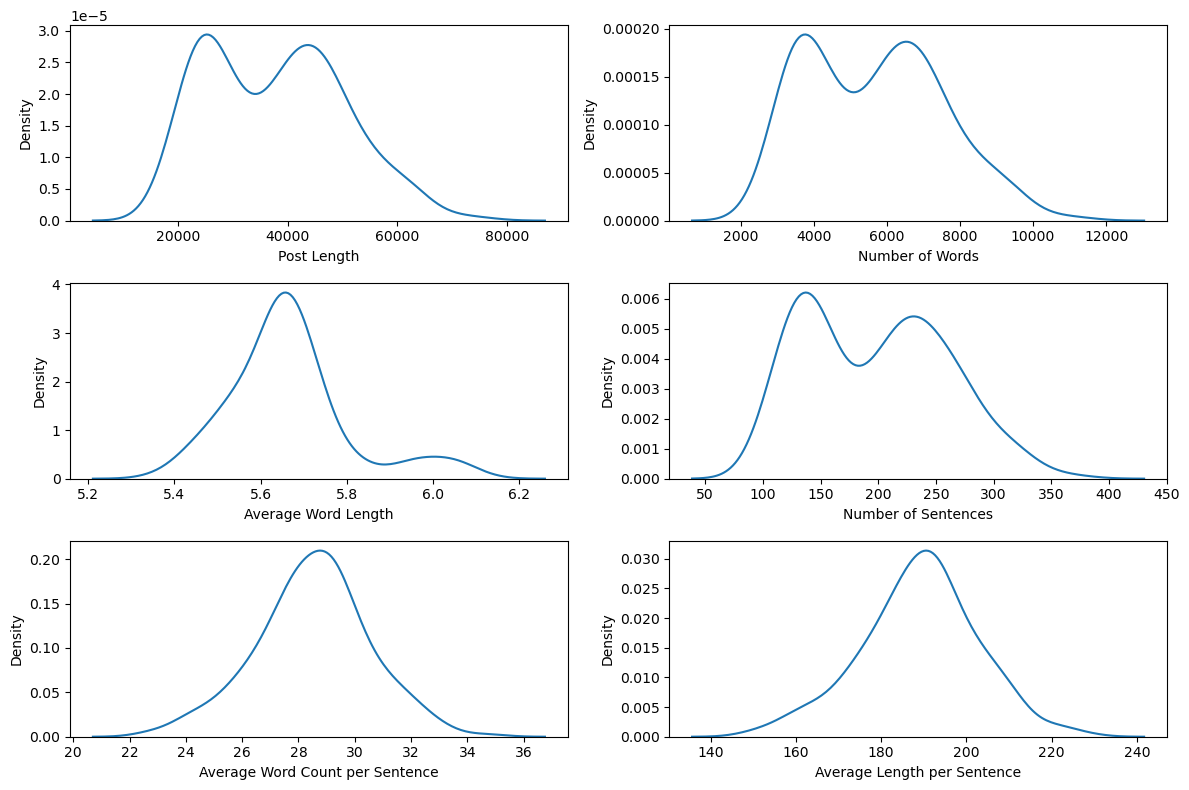

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(12,8))

sns.kdeplot(fomc_raw, x='char_length', ax=ax[0, 0])
ax[0, 0].set_xlabel('Post Length')

sns.kdeplot(fomc_raw, x='word_count', ax=ax[0, 1])
ax[0, 1].set_xlabel('Number of Words')

sns.kdeplot(fomc_raw, x='mean_word_length', ax=ax[1, 0])
ax[1, 0].set_xlabel('Average Word Length')


sns.kdeplot(fomc_raw, x='count_sentence', ax=ax[1, 1])
ax[1, 1].set_xlabel('Number of Sentences')

sns.kdeplot(fomc_raw, x='mean_word_per_sentence', ax=ax[2, 0])
ax[2, 0].set_xlabel('Average Word Count per Sentence')

sns.kdeplot(fomc_raw, x='mean_char_per_sentence', ax=ax[2, 1])
ax[2, 1].set_xlabel('Average Length per Sentence')

plt.tight_layout()

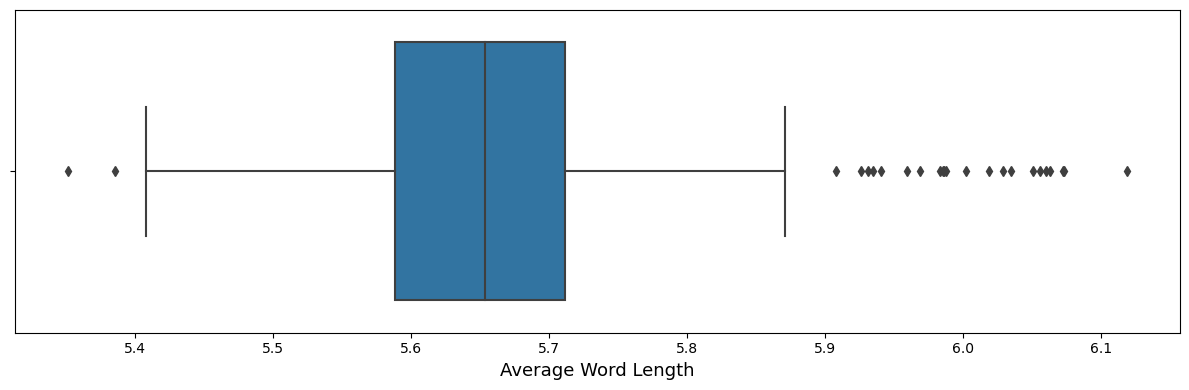

In [9]:
plt.figure(figsize=(12, 4))
sns.boxplot(fomc_raw, x='mean_word_length')

# plt.title('Average Word Length', fontdict={'fontsize': 18, 'fontweight':5}, loc='center')
plt.xlabel('Average Word Length', fontdict={'fontsize': 13})
plt.tight_layout()
# plt.savefig('../images/average_word_length.png', dpi=300);

## Term Frequency Analysis

Term frequency analysis is a valuable tool in natural language processing (NLP) as it provides insights into the significance and relevance of words within a given document. By calculating the frequency of each term in a text, we can identify the most commonly used words, which often reflect the main themes and topics. 

Howerve, we cannot proceed to the analysis immediately. we need to preprocess the data first. There should not be any missing values, any puctuations, any capital letter or any stopwords. To improve analysis accuracy, an extra preprocessing step has been added: lemmatizing words based on their part of speech. This step normalizes words, reducing them to their base form and considering grammatical context. By doing so, variations are consolidated, enhancing data quality and coherence for more precise insights.

In [10]:
custom_words = ['would', 'committee', 'participant']
stop_words = set(stopwords.words('english'))
stop_words.update(custom_words)

In [11]:
bow=Counter(fomcwordcloud).items()
bow = {word:count for word, count in bow if word not in list(stop_words)}
bow = pd.DataFrame(bow.items(), columns=['word', 'frequency'])
bow.sort_values('frequency', ascending=False, inplace=True)
bow.head(5)

word  frequency
3       market      12020
149       rate      11320
401  inflation      10569
363   economic       8500
128      price       8483

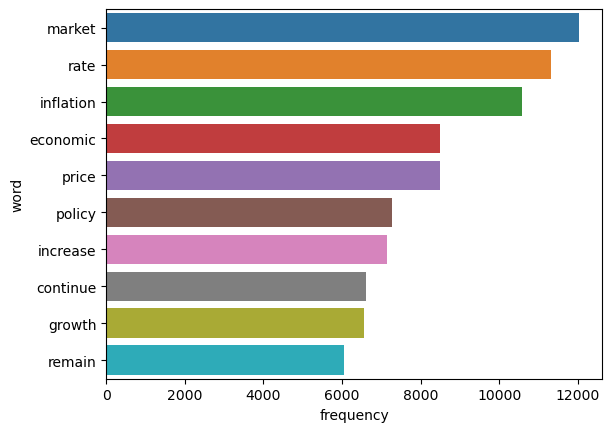

In [12]:
sns.barplot(bow.head(10), y = 'word', x='frequency');

##  Most Common Words

In addition to analyzing the term frequency of words, it is also valuable to examine the words appearing in each post, as it provides a more comprehensive understanding of the topics being discussed. To carry out this analysis, the Scikit-learn library's CountVectorizer, which is a part of the feature extraction module, is utilized. The CountVectorizer allows for the transformation of text data into a numerical representation by creating a matrix of word frequencies.

In [13]:
custom_words = ['would', 'committee', 'participants']
stop_words = set(stopwords.words('english'))
stop_words.update(custom_words)

In [14]:
lemmatized_text = fomc_raw['fomc_text'].apply(pos_lemmatizer)

In [15]:
cvec = CountVectorizer(stop_words=list(stop_words))
X = cvec.fit_transform(lemmatized_text)
df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names_out())

common_words_unigrams = df.sum().sort_values(ascending=False).head(10)

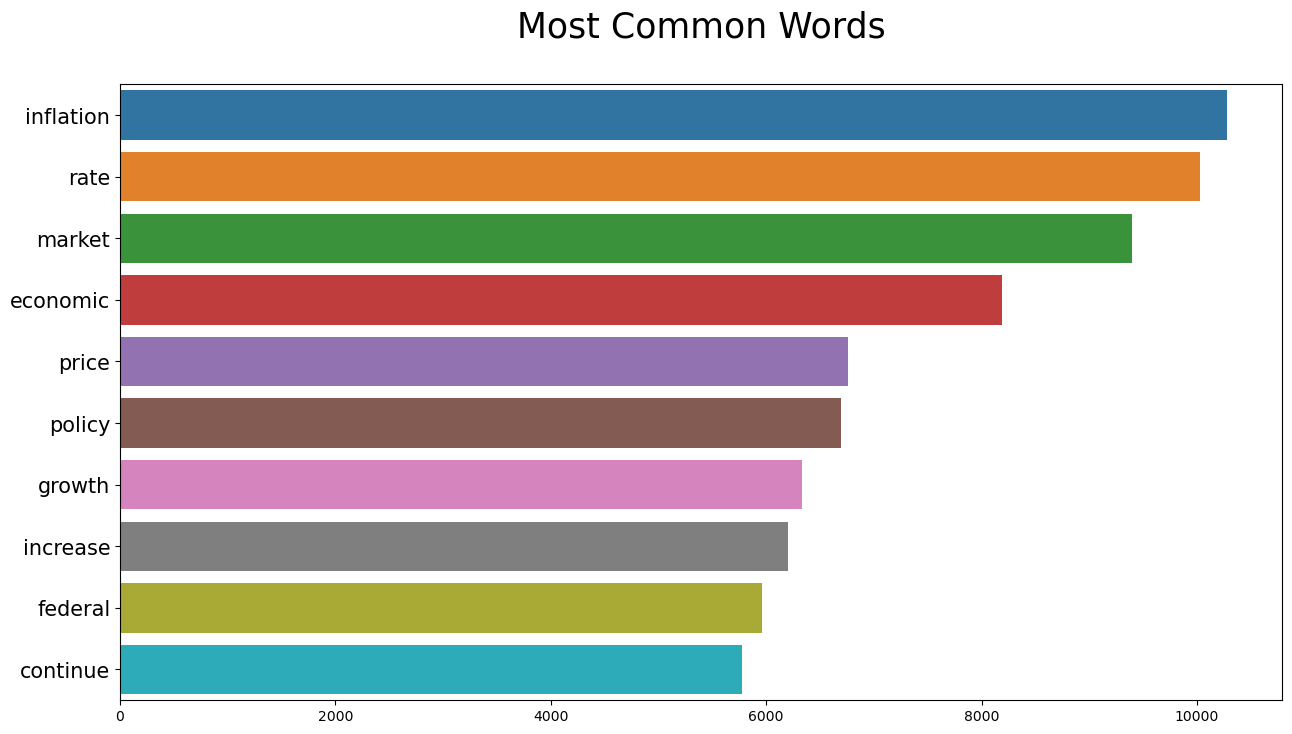

In [18]:
plt.figure(figsize=(15, 8))
sns.barplot(y = common_words_unigrams.index, x= common_words_unigrams)
plt.title('Most Common Words\n', fontsize=25)
plt.yticks(fontsize=15)


plt.savefig('../images/most_common_words.png', dpi=1200);

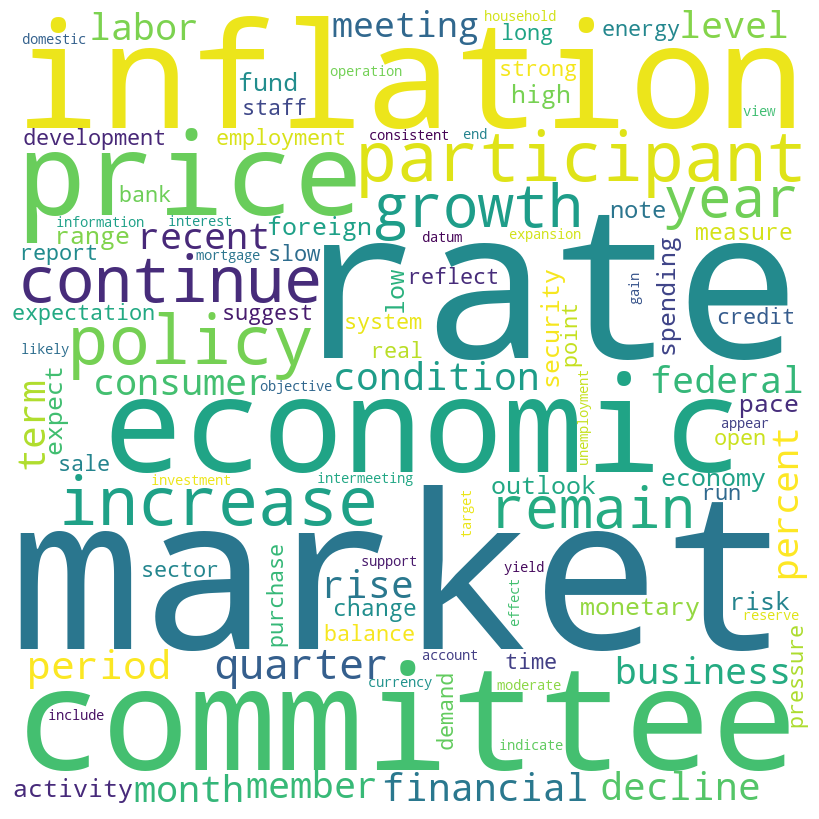

In [19]:
plt.figure(figsize=(8,8))
wordcloud = WordCloud(
    background_color="white",  # Set the background color
    colormap="viridis",  # Choose a colormap for the colors of the words
    width=800, height=800,  # Set the size of the word cloud canvas
    max_words=100,  # Limit the maximum number of words shown in the cloud
    contour_color='steelblue',  # Set the color for word cloud contour lines
    contour_width=3,
    collocations=False,
    # mode ='RGBA',
    # color_func=lambda *args, **kwargs: "Blue"
    
).generate(','.join(fomcwordcloud)) # NB. 'join' method used to convert the documents list to text format
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../images/wordcloud_unigram.png', dpi=600)

In [21]:
cvec = CountVectorizer(stop_words=list(stop_words), ngram_range=(2,2))
X = cvec.fit_transform(lemmatized_text)
df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names_out())

common_words_bigrams = df.sum().sort_values(ascending=False).head(10)

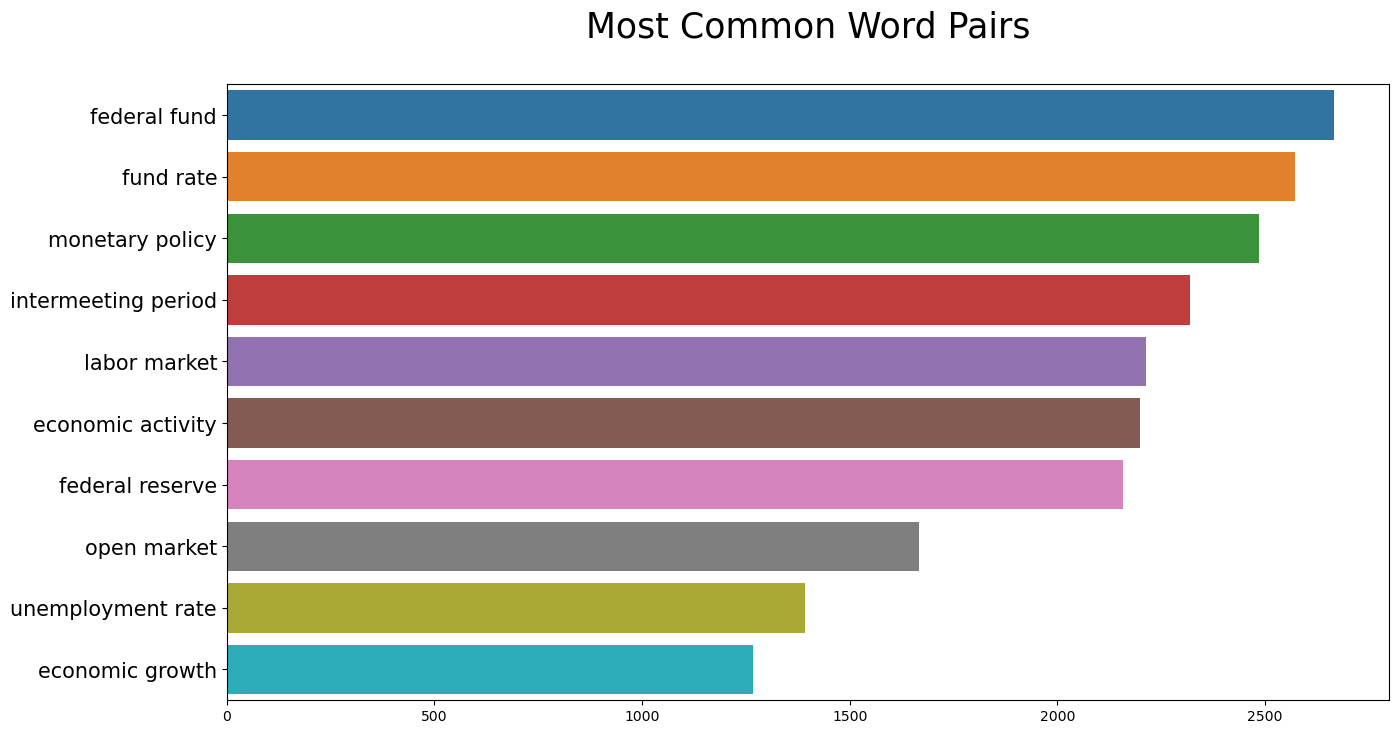

In [23]:
plt.figure(figsize=(15, 8))
sns.barplot(y = common_words_bigrams.index, x= common_words_bigrams)
plt.title('Most Common Word Pairs\n', fontsize=25)
plt.yticks(fontsize=15)
plt.savefig('../images/most_common_bigrams.png', dpi=600);

In [137]:
data = pd.read_pickle('../data/full_data.pkl')

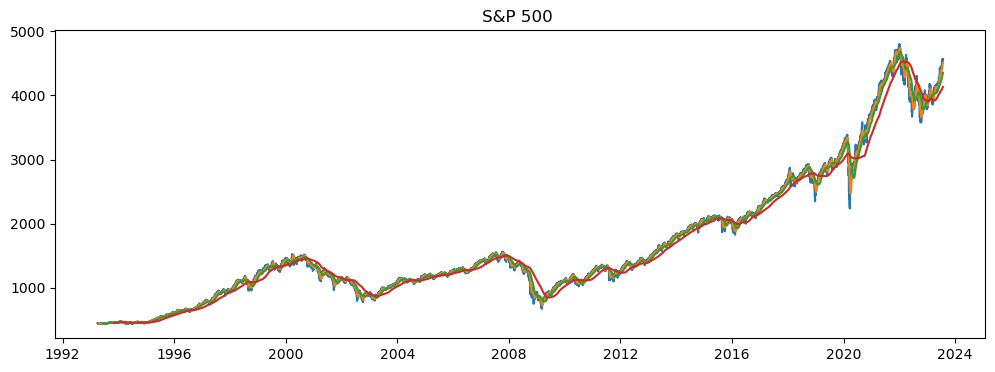

In [66]:
plt.figure(figsize=(12,4))
plt.plot(data['Adj Close'])
plt.plot(data['Adj Close'].rolling(15).mean())
plt.plot(data['Adj Close'].rolling(50).mean())
plt.plot(data['Adj Close'].rolling(150).mean())

plt.title('S&P 500 ');

In [ ]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
cf.go_offline(True)

In [51]:
plt.figure(figsize=(12,4))

# Line plot of Open.
data['Adj Close'].iplot()
fig.write_html("../images/sp.html")

Date
1993-04-01            NaN
1993-04-02            NaN
1993-04-05            NaN
1993-04-06            NaN
1993-04-07     443.574005
                 ...     
2023-07-20    4536.756055
2023-07-21    4542.940039
2023-07-24    4549.310059
2023-07-25    4551.806055
2023-07-26    4552.012012
Name: Adj Close, Length: 7634, dtype: float64

<Figure size 1200x800 with 0 Axes>

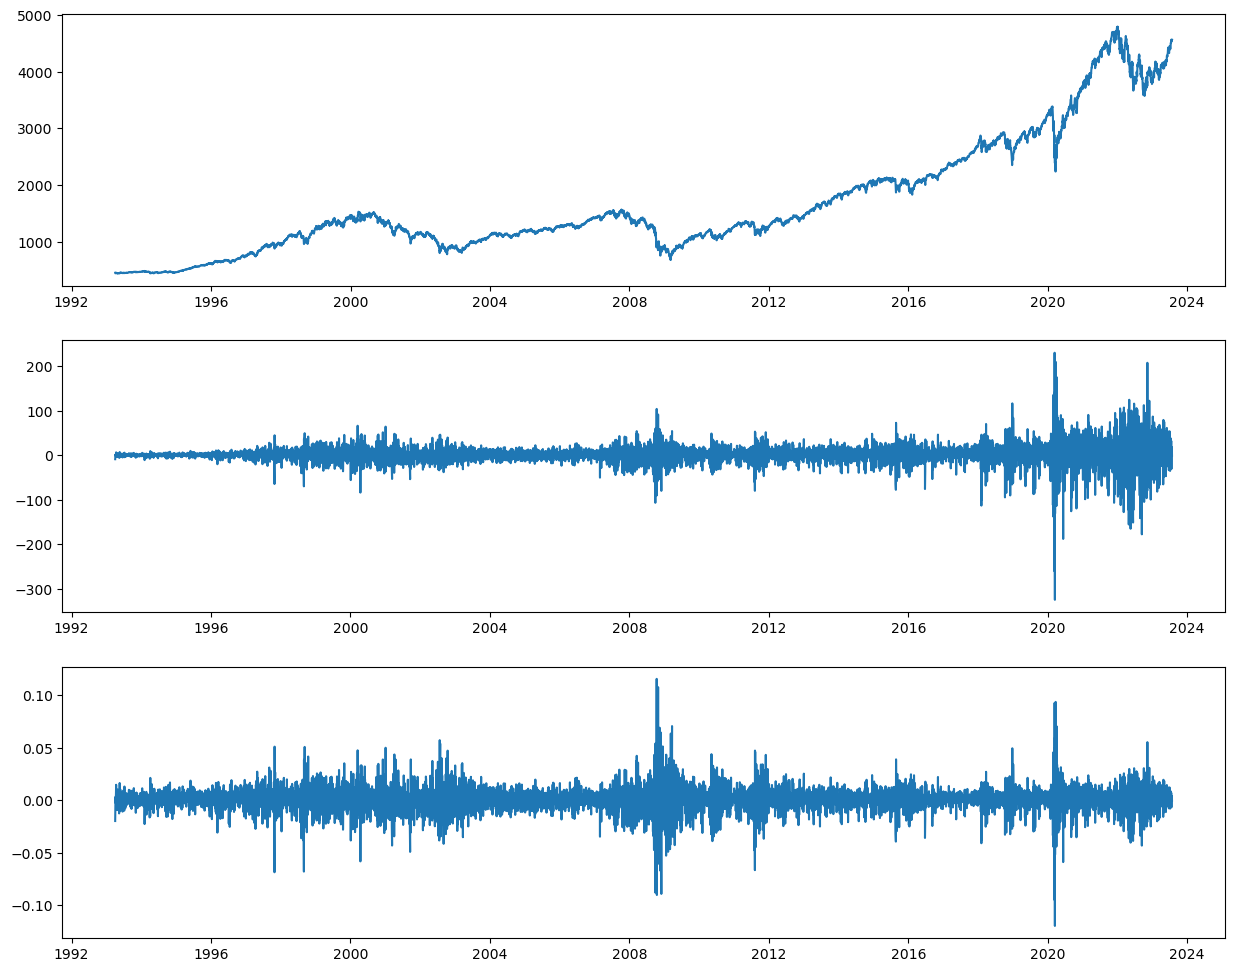

In [73]:
plt.figure(figsize=(12, 8))

fig, ax = plt.subplots(3, figsize=(15, 12));
ax[0].plot(data['Adj Close']);
ax[1].plot(data['Adj Close'].diff());
ax[2].plot(data['Adj Close'].pct_change());
plt.show();

In [75]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

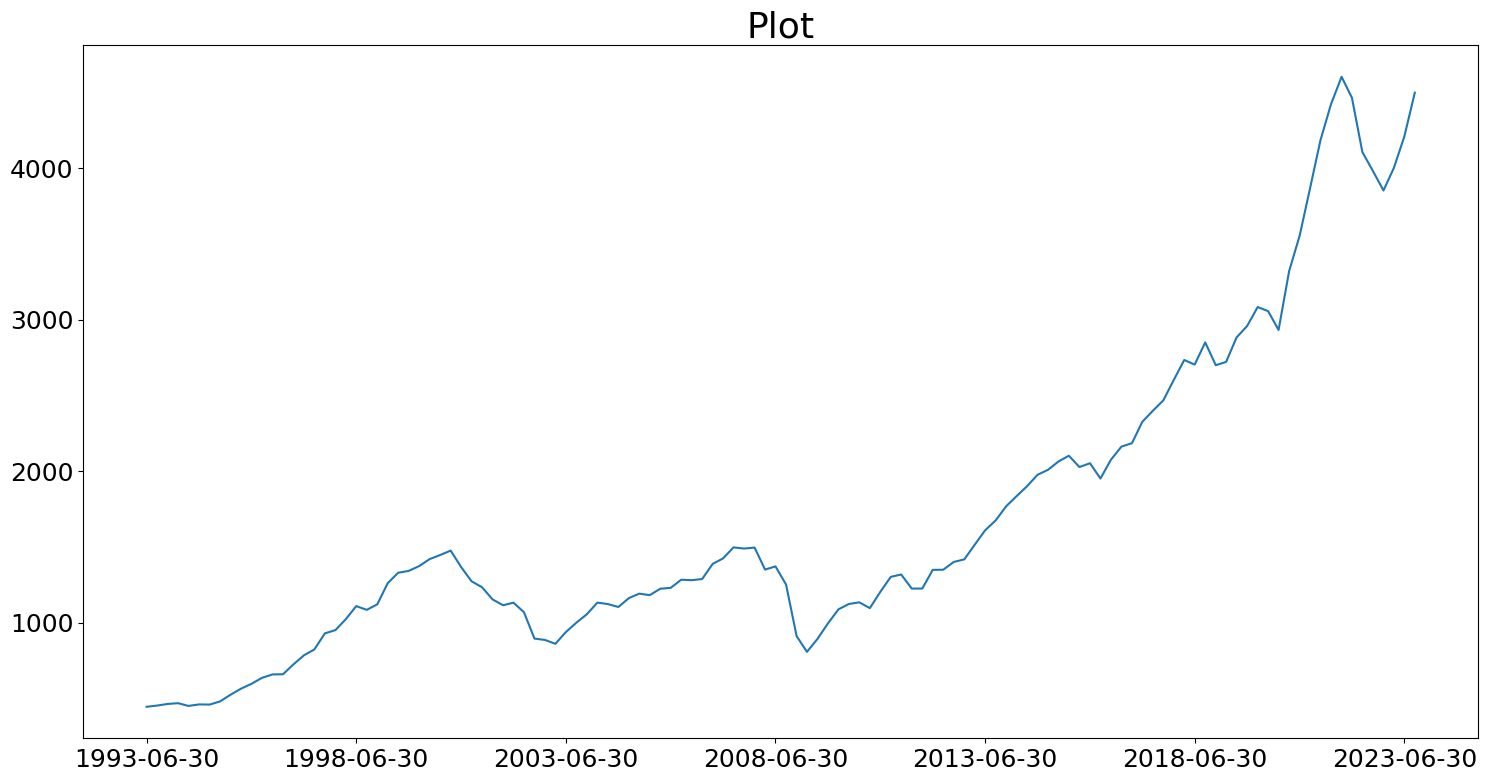

In [76]:
plot_series(data.resample('Q').mean(), cols=['Adj Close'], title='Plot', steps=20)

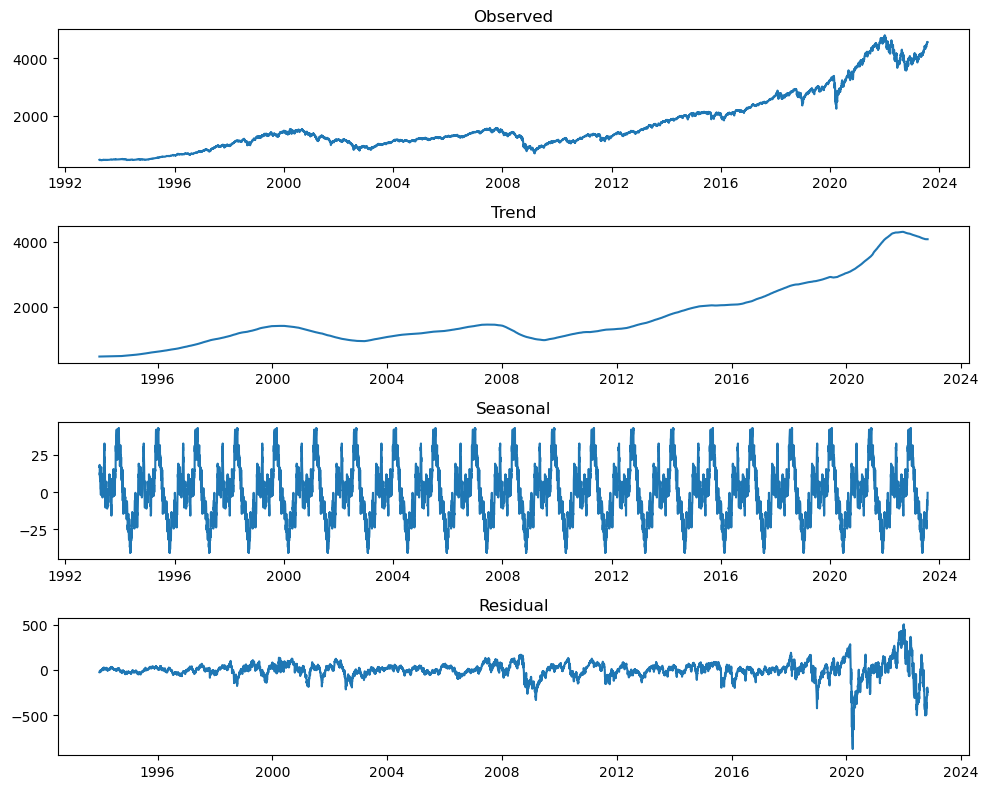

In [80]:
decomp = seasonal_decompose(data['Adj Close'], period=365)
# decomp.plot();

plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(decomp.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

/Users/sdastan/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



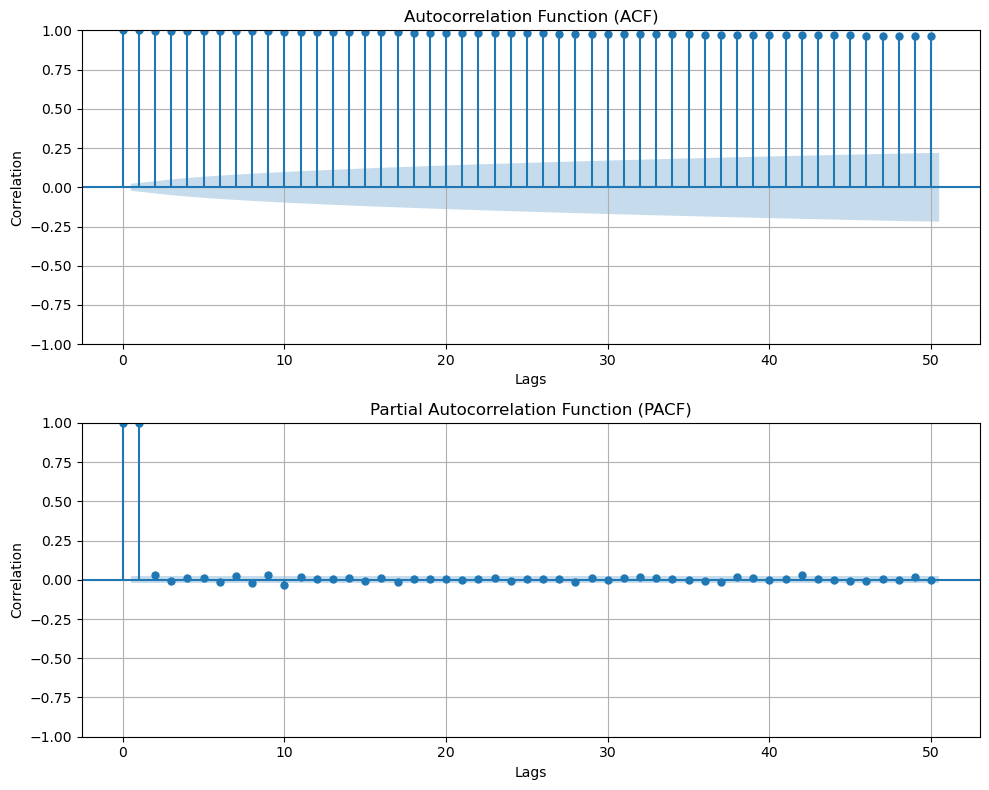

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(data['Adj Close'], lags=50, ax=ax1, alpha=0.05)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation')
ax1.grid(True)

# Plot PACF
plot_pacf(data['Adj Close'], lags=50, ax=ax2, alpha=0.05)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [407]:
fred = pd.read_pickle('../data/fred.pkl')

In [412]:
fred['growth(yoy)']= fred[['real_gdp']].dropna().pct_change(4)*100
fred['inflation(yoy)'] = fred[['cpi']].dropna().pct_change(12)*100

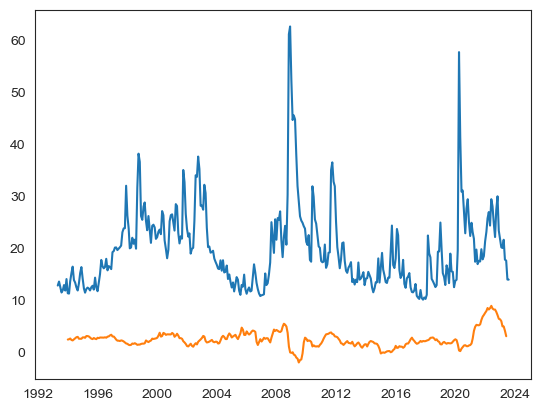

In [420]:
plt.plot(data['vix'].resample('M').mean())
plt.plot(fred['inflation(yoy)'].dropna())

<Axes: xlabel='date'>

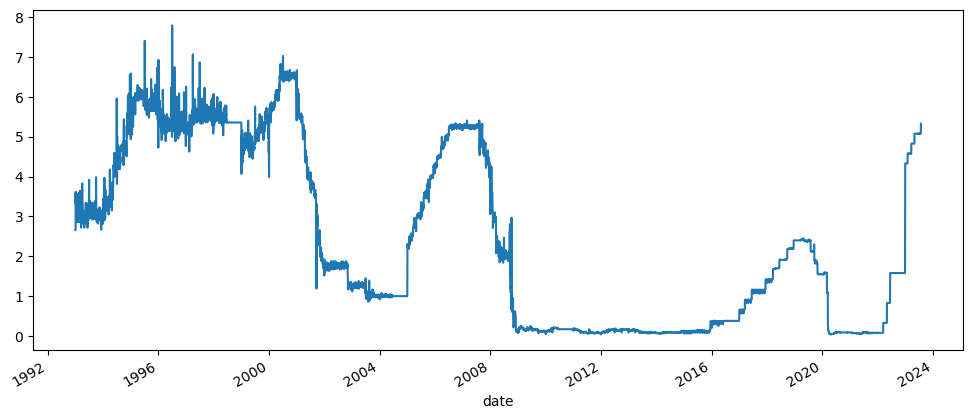

In [105]:
plt.figure(figsize=(12, 5))
fred['ffr'].ffill().plot()

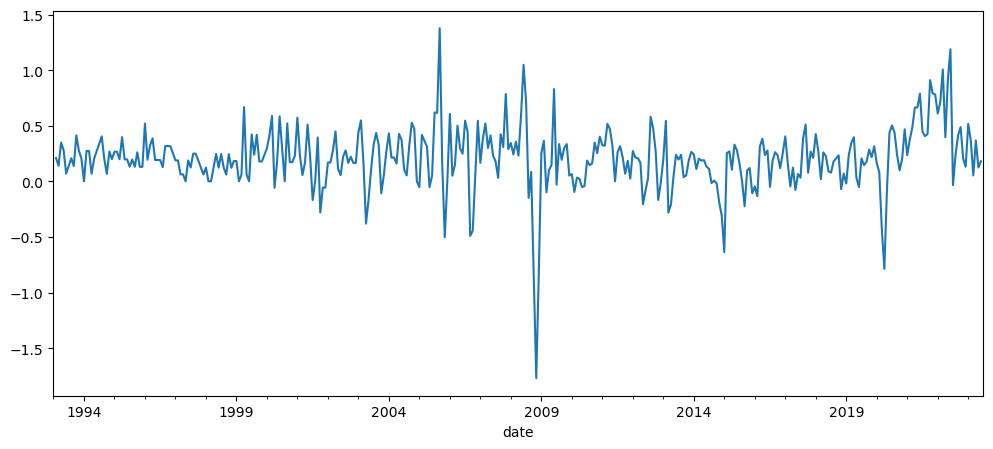

In [122]:
plt.figure(figsize=(12, 5))
fred['inflation'].resample('M').mean().plot();

<Axes: xlabel='date'>

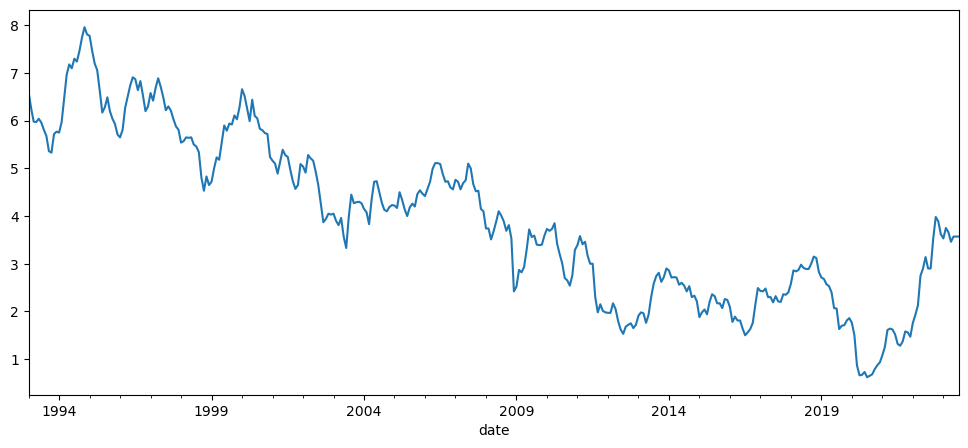

In [123]:
plt.figure(figsize=(12, 5))
fred['10_year_treasury_yeild'].ffill().resample('M').mean().plot()

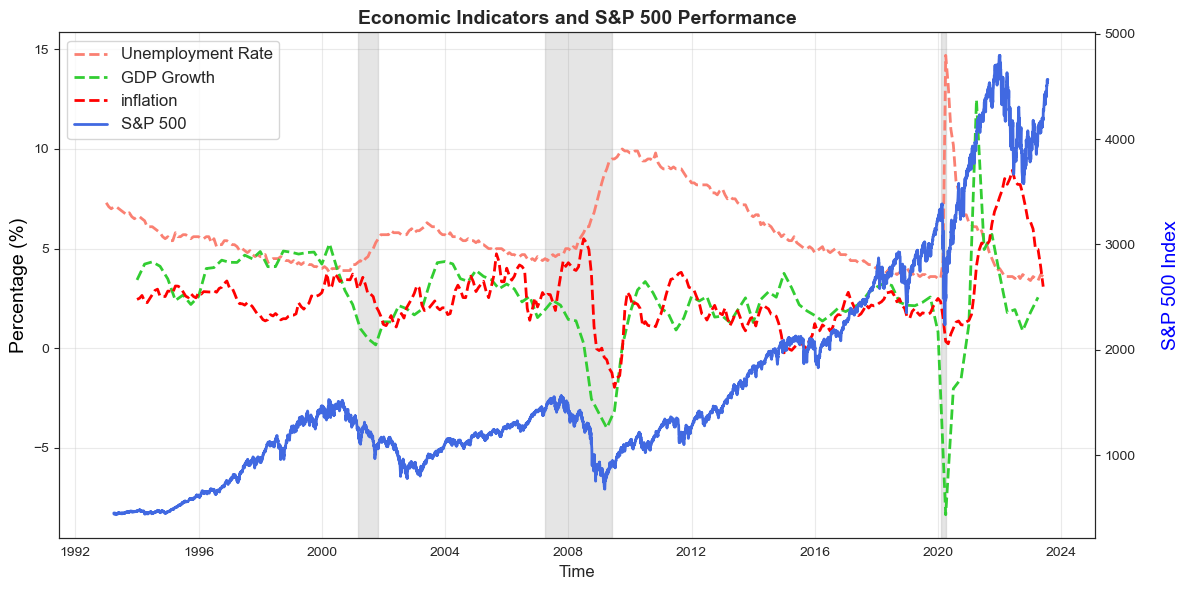

In [476]:
sns.set_style('white')

# Create the subplot with twin y-axis
fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

ax0.plot(fred['unemployment_rate'].dropna(), color='salmon', label='Unemployment Rate', linestyle='dashed', linewidth=2)
ax0.plot(fred['growth(yoy)'].dropna(), color='limegreen', label='GDP Growth', linestyle='--', linewidth=2)
ax0.plot(fred['inflation(yoy)'].dropna(), color='red', label='inflation', linestyle='--', linewidth=2)

ax1.plot(data['Adj Close'], color='royalblue', label='S&P 500', linewidth=2)

ax0.set_xlabel('Time', fontsize=12)
ax0.set_ylabel('Percentage (%)', color='black', fontsize=14)
ax1.set_ylabel('\nS&P 500 Index', color='b', fontsize=14)

# Set the legend for both axes with a better position
lines, labels = ax0.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

# Set grid transparency for a cleaner look
ax0.grid(alpha=0.4)

# https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
ax0.axvspan(datetime.strptime('2007-04-01', '%Y-%m-%d'), 
            datetime.strptime('2009-05-30', '%Y-%m-%d'), alpha=0.2, color='grey')

ax0.axvspan(datetime.strptime('2001-03-01', '%Y-%m-%d'), 
            datetime.strptime('2001-10-30', '%Y-%m-%d'), alpha=0.2, color='grey')

ax0.axvspan(datetime.strptime('2020-02-01', '%Y-%m-%d'), 
            datetime.strptime('2020-03-30', '%Y-%m-%d'), alpha=0.2, color='grey')

# Set title with an improved font size and weight
plt.title('Economic Indicators and S&P 500 Performance', fontsize=14, fontweight='bold');

plt.tight_layout()
# Show the plot
plt.savefig('../images/sp500_ur_growth.png', dpi=600)

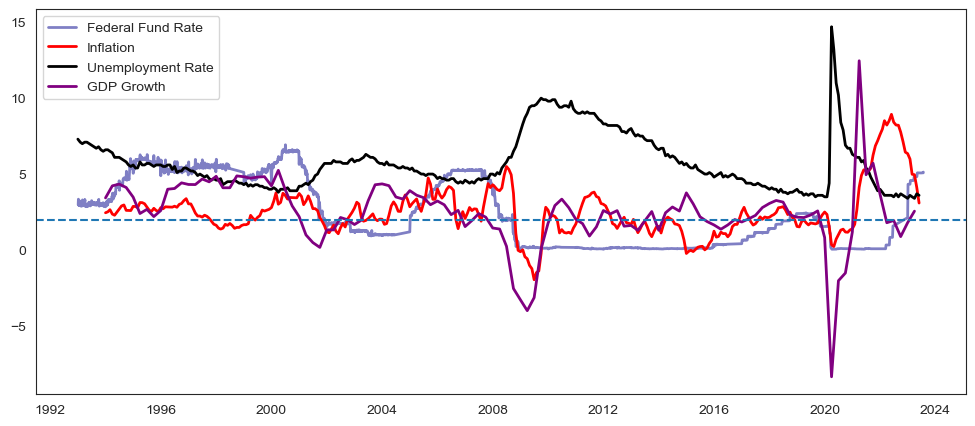

In [488]:
plt.figure(figsize=(12, 5))
plt.plot(fred['ffr'].dropna().rolling(5).mean(), color='darkblue', label='Federal Fund Rate', linewidth=2, alpha=.5)
plt.plot(fred['inflation(yoy)'].dropna(), color='red', label='Inflation', linewidth=2)
plt.plot(fred['unemployment_rate'].dropna(), color='black', label='Unemployment Rate', linewidth=2)
plt.plot(fred['growth(yoy)'].dropna(), color='purple', label='GDP Growth', linewidth=2)

plt.axhline(y=2, ls='dashed')
plt.legend()

<Axes: xlabel='date'>

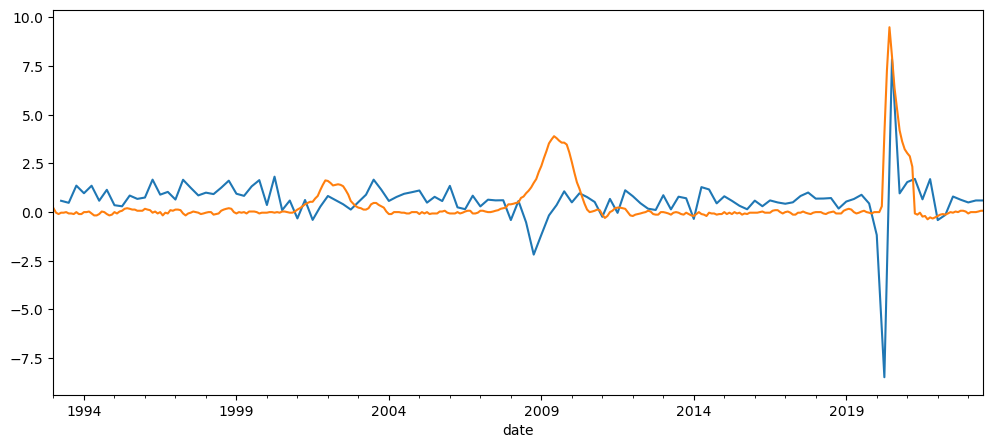

In [151]:
plt.figure(figsize=(12, 5))
fred['growth'].ffill().resample('Q').mean().plot()
fred['sahm'].ffill().resample('M').mean().plot()


<Axes: xlabel='date'>

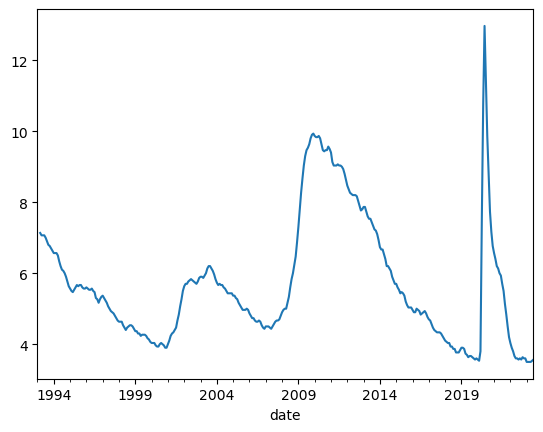

In [146]:
fred['unemployment_rate'].dropna().rolling(3).mean().plot()

In [207]:
topics = pd.read_pickle('../data/fomc_topic_modeling.pkl').iloc[:, -6:]
topics.head()

topic 1  consumption  foreign_exchange_rate  inflation  \
1993-02-03  0.217142     0.222028               0.071233   0.354325   
1993-03-23  0.052435     0.337770               0.102628   0.422744   
1993-05-18  0.044406     0.325946               0.120336   0.428469   
1993-07-07  0.031498     0.281643               0.069809   0.522031   
1993-08-17  0.036917     0.411438               0.112277   0.312171   

            financial_market   topic 6  
1993-02-03          0.077838  0.057434  
1993-03-23          0.049573  0.034851  
1993-05-18          0.042354  0.038488  
1993-07-07          0.053767  0.041252  
1993-08-17          0.081001  0.046197

In [369]:
#2007
date_range07_start = datetime.strptime('2007-04-01', '%Y-%m-%d')
date_range07_end = datetime.strptime('2009-05-30', '%Y-%m-%d')

#2001
date_range01_start = datetime.strptime('2001-03-01', '%Y-%m-%d')
date_range01_end = datetime.strptime('2001-10-30', '%Y-%m-%d')

#2020
date_range20_start = datetime.strptime('2020-02-01', '%Y-%m-%d')
date_range20_end = datetime.strptime('2020-03-30', '%Y-%m-%d')

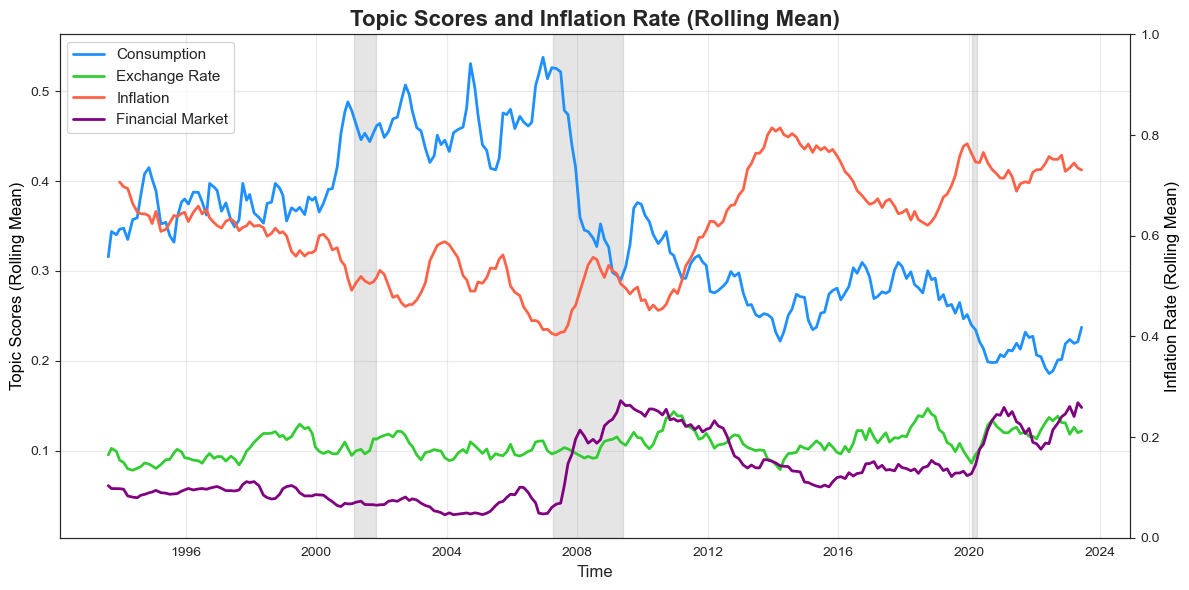

In [370]:
sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

ax0.plot(topics['consumption'].rolling(5).mean(), label='Consumption', color='dodgerblue', linewidth=2)
ax0.plot(topics['foreign_exchange_rate'].rolling(5).mean(), label='Exchange Rate', color='limegreen', linewidth=2)
ax0.plot(topics['inflation'].rolling(8).mean(), label='Inflation', color='tomato', linewidth=2)
ax0.plot(topics['financial_market'].rolling(5).mean(), label='Financial Market', color='purple', linewidth=2)

# ax1.plot(fred['inflation'].dropna().rolling(5).mean(), label='Inflation Rate', 
#          color='black', linewidth=2, ls='dotted')

ax0.set_xlabel('Time', fontsize=12)
ax0.set_ylabel('Topic Scores (Rolling Mean)', color='black', fontsize=12)
ax1.set_ylabel('Inflation Rate (Rolling Mean)', color='black', fontsize=12)

lines0, labels0 = ax0.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines0 + lines1, labels0 + labels1, loc='upper left', fontsize=11)

ax0.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
ax0.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
ax0.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

ax0.grid(alpha=0.4)

plt.title('Topic Scores and Inflation Rate (Rolling Mean)', fontsize=16, fontweight='bold')

plt.tight_layout()  
plt.show()

In [326]:
sentiment_mc = pd.read_pickle('../data/fomc_raw_laughran_mcdonald_sentiment.pkl')
sentiment_zstc = pd.read_pickle('../data/fomc_raw_zstc_sentiment.pkl')

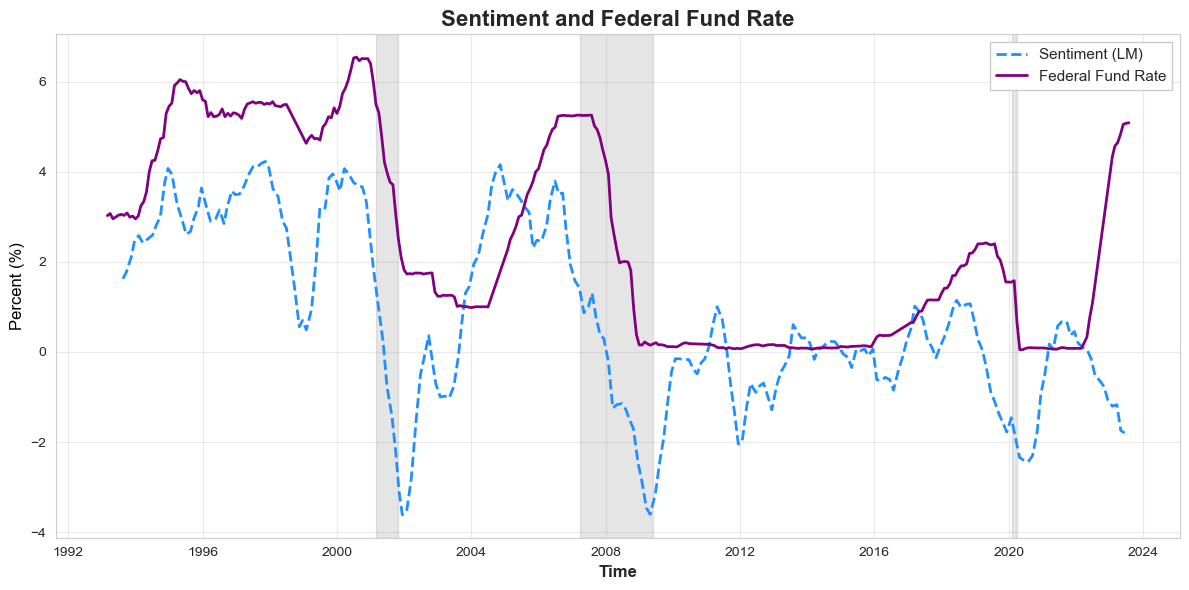

In [372]:
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))

plt.plot(sentiment_mc['sentiment_mc'].rolling(5).mean(), 
         label='Sentiment (LM)', color='dodgerblue', linewidth=2, linestyle='dashed')

plt.plot(fred['ffr'].resample('M').mean().dropna(), 
         label='Federal Fund Rate', color='purple', linewidth=2)

plt.xlabel('Time', fontsize=12, fontweight='bold', fontname='Arial')
plt.ylabel('Percent (%)', color='black', fontsize=12, fontname='Arial')
plt.title('Sentiment and Federal Fund Rate', fontsize=16, fontweight='bold', fontname='Arial')

plt.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
plt.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
plt.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

plt.grid(alpha=0.4)

plt.legend(loc='upper right', fontsize=11, framealpha=1.0, fancybox=False)

plt.tight_layout()
plt.show()

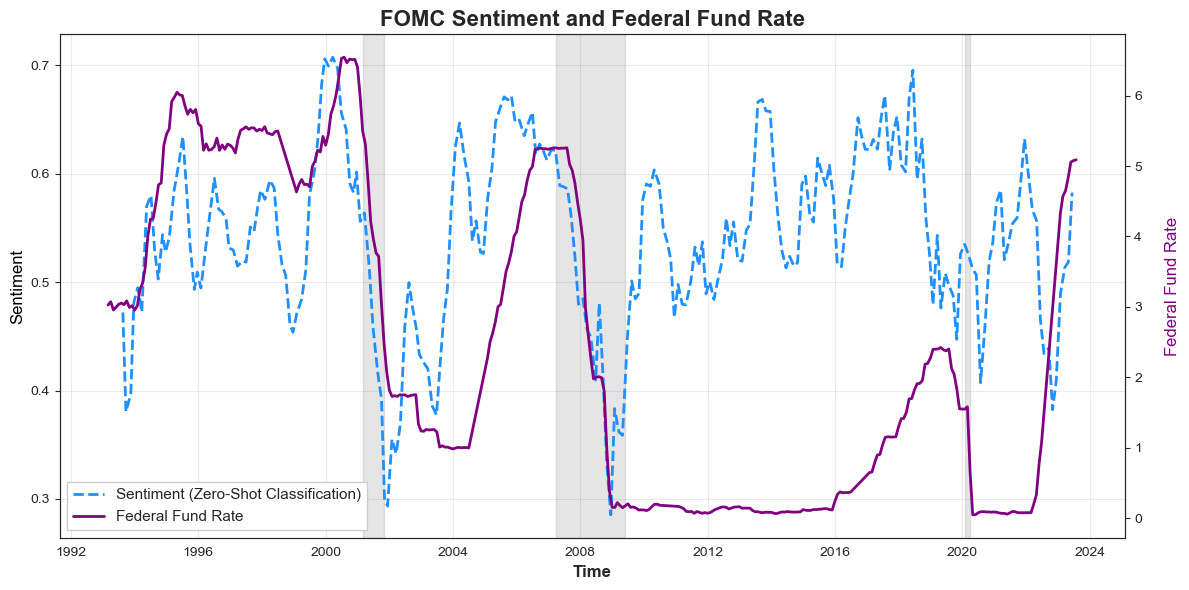

In [373]:
sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

ax0.plot(sentiment_zstc['sentiment_zstc'].rolling(5).mean(), 
         label='Sentiment (Zero-Shot Classification)', color='dodgerblue', linewidth=2, linestyle='dashed')

ax1.plot(fred['ffr'].resample('M').mean().dropna(), 
         label='Federal Fund Rate', color='purple', linewidth=2)

ax0.set_xlabel('Time', fontsize=12, fontweight='bold', fontname='Arial')
ax0.set_ylabel('Sentiment', color='black', fontsize=12, fontname='Arial')
ax1.set_ylabel('\nFederal Fund Rate', color='purple', fontsize=12, fontname='Arial')

ax0.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
ax0.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
ax0.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

ax0.grid(alpha=0.4)

plt.title('FOMC Sentiment and Federal Fund Rate', fontsize=16, fontweight='bold', fontname='Arial')

lines0, labels0 = ax0.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines0 + lines1, labels0 + labels1, loc='lower left', fontsize=11, framealpha=1.0, fancybox=False)

plt.tight_layout();



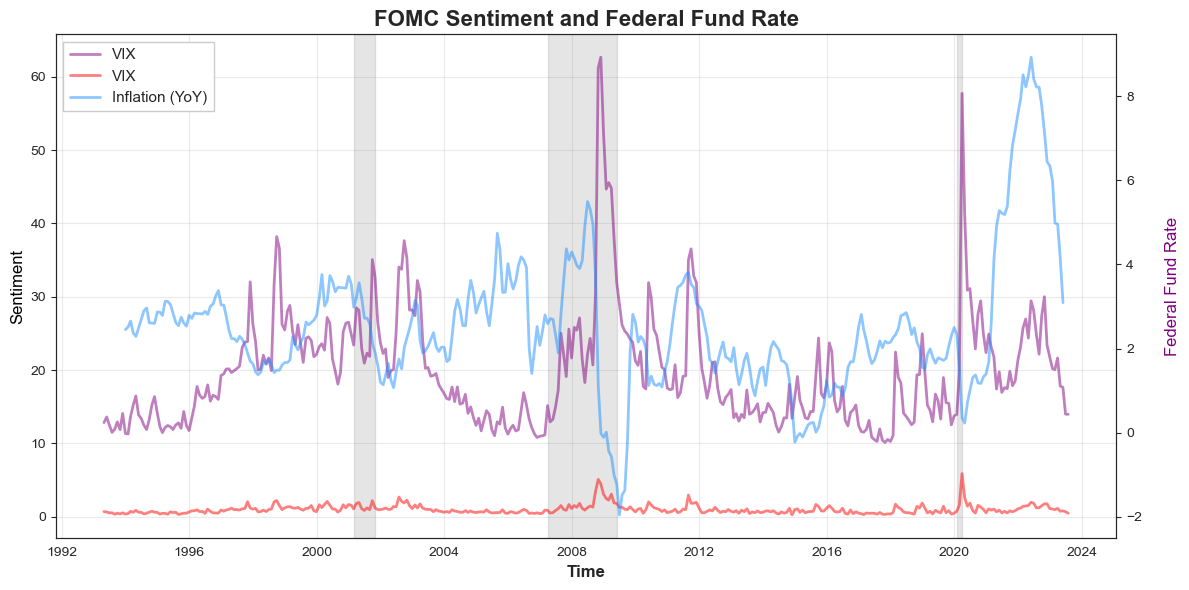

In [474]:
sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

# ax0.plot(sentiment_zstc['sentiment_zstc'].rolling(5).mean(), 
#          label='Sentiment (Zero-Shot Classification)', color='dodgerblue', linewidth=2, linestyle='dashed')
ax0.plot(data['vix'].resample('M').mean(),label='VIX', color='purple', linewidth=2, alpha=0.5)
ax0.plot(data['pct_change_adj_close'].resample('M').std(),label='VIX', color='red', linewidth=2, alpha=0.5)


ax1.plot(fred['inflation(yoy)'].dropna(),
         label='Inflation (YoY)', color='dodgerblue', linewidth=2,alpha=0.5)
# ax1.plot(fred['ffr'].resample('M').mean().dropna(), 
#          label='Federal Fund Rate', color='purple', linewidth=2)

ax0.set_xlabel('Time', fontsize=12, fontweight='bold', fontname='Arial')
ax0.set_ylabel('Sentiment', color='black', fontsize=12, fontname='Arial')
ax1.set_ylabel('\nFederal Fund Rate', color='purple', fontsize=12, fontname='Arial')

ax0.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
ax0.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
ax0.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

ax0.grid(alpha=0.4)

plt.title('FOMC Sentiment and Federal Fund Rate', fontsize=16, fontweight='bold', fontname='Arial')

lines0, labels0 = ax0.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines0 + lines1, labels0 + labels1, loc='upper left', fontsize=11, framealpha=1.0, fancybox=False)

plt.tight_layout();

In [453]:
new = pd.DataFrame()
new['Adj Close'] = data['Adj Close']
new['close_std'] = data['Adj Close'].rolling(30).std()
new['close_ma30'] = data['Adj Close'].rolling(30).mean()
new['upper'] = new['close_ma30'] + 2*new['close_std']
new['lower'] = new['close_ma30'] - 2*new['close_std']

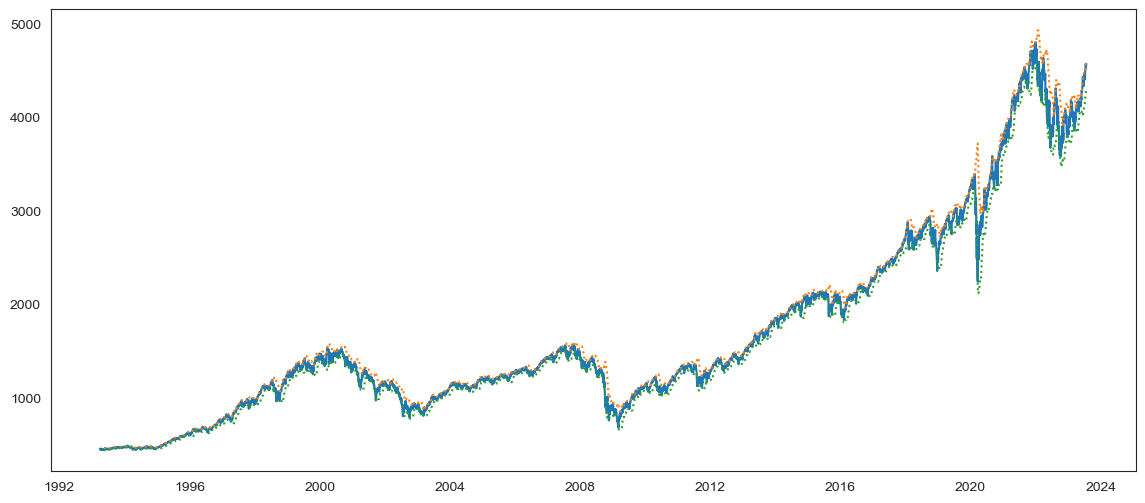

In [460]:
plt.figure(figsize=(14, 6))
plt.plot(new['Adj Close'])
plt.plot(new['upper'], ls='dotted')
plt.plot(new['lower'], ls='dotted')

#### Bollinger Bands

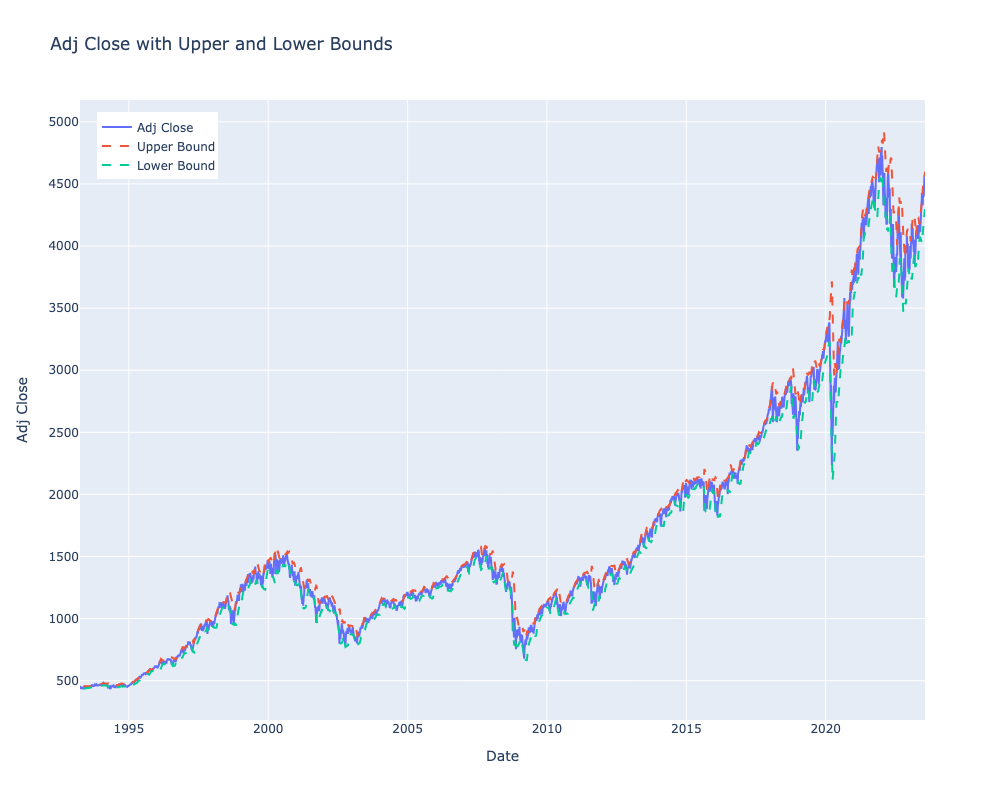

In [464]:
import plotly.graph_objects as go
sns.set_style('white')
fig = go.Figure()

fig.add_trace(go.Scatter(x=new.index, y=new['Adj Close'], mode='lines', name='Adj Close'))

fig.add_trace(go.Scatter(x=new.index, y=new['upper'], mode='lines', name='Upper Bound', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=new.index, y=new['lower'], mode='lines', name='Lower Bound', line=dict(dash='dash')))

fig.update_layout(
    title='Adj Close with Upper and Lower Bounds',
    xaxis_title='Date',
    yaxis_title='Adj Close',
    showlegend=True, 
    legend=dict(x=0.02, y=0.98),  
    height=800  
)


fig.show()

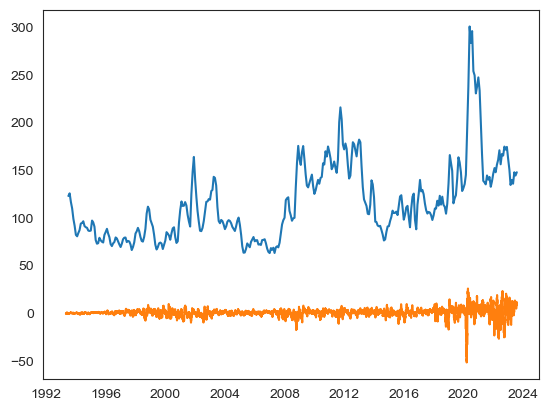

In [473]:
plt.plot(data['Three_Component_Index'].resample('M').last().rolling(3).mean())
plt.plot(data['Adj Close'].diff().rolling(20).mean())

Adj Close     Volume  pct_change_adj_close  \
Date                                                      
1993-04-01  450.299988  234530000             -0.303324   
1993-04-02  441.390015  323330000             -1.978675   
1993-04-05  442.290009  296080000              0.203900   

            lag_pct_change_adj_close  lag_pct_change_volume  \
Date                                                          
1993-04-01                 -0.066373              20.762144   
1993-04-02                 -0.303324             -15.996275   
1993-04-05                 -1.978675              37.862960   

            lag_ma5_pct_change_adj_close   topic 1  consumption  \
Date                                                              
1993-04-01                      0.161433  0.052435      0.33777   
1993-04-02                     -0.024659  0.052435      0.33777   
1993-04-05                     -0.282885  0.052435      0.33777   

            foreign_exchange_rate  inflation_x  ...  us_china_exchange_rate  \
Date                                            ...                           
1993-04-01               0.102628     0.422744  ...                  5.7333   
1993-04-02               0.102628     0.422744  ...                  5.7333   
1993-04-05               0.102628     0.422744  ...                  5.7333   

            us_japan_exchange_rate  sahm  inflation_y    growth  \
Date                                                              
1993-04-01                   114.1 -0.03     0.348918  0.582113   
1993-04-02                   114.2 -0.03     0.348918  0.582113   
1993-04-05                   113.6 -0.03     0.348918  0.582113   

            Three_Component_Index  News_Based_Policy_Uncert_Index  \
Date                                                                
1993-04-01             109.256836                       89.651123   
1993-04-02             109.256836                       89.651123   
1993-04-05             109.256836                       89.651123   

            price_increase  boolean   Difference  
Date                                              
1993-04-01               0    False -1222.152995  
1993-04-02               0    False -1231.062968  
1993-04-05               1    False -1230.162974  

[3 rows x 31 columns]

Adj Close     Volume  pct_change_adj_close  \
Date                                                      
1993-04-01  450.299988  234530000             -0.303324   
1993-04-02  441.390015  323330000             -1.978675   
1993-04-05  442.290009  296080000              0.203900   

            lag_pct_change_adj_close  lag_pct_change_volume  \
Date                                                          
1993-04-01                 -0.066373              20.762144   
1993-04-02                 -0.303324             -15.996275   
1993-04-05                 -1.978675              37.862960   

            lag_ma5_pct_change_adj_close   topic 1  consumption  \
Date                                                              
1993-04-01                      0.161433  0.052435      0.33777   
1993-04-02                     -0.024659  0.052435      0.33777   
1993-04-05                     -0.282885  0.052435      0.33777   

            foreign_exchange_rate  inflation_x  ...  us_japan_exchange_rate  \
Date                                            ...                           
1993-04-01               0.102628     0.422744  ...                   114.1   
1993-04-02               0.102628     0.422744  ...                   114.2   
1993-04-05               0.102628     0.422744  ...                   113.6   

            sahm  inflation_y    growth  Three_Component_Index  \
Date                                                             
1993-04-01 -0.03     0.348918  0.582113             109.256836   
1993-04-02 -0.03     0.348918  0.582113             109.256836   
1993-04-05 -0.03     0.348918  0.582113             109.256836   

            News_Based_Policy_Uncert_Index  price_increase  boolean  \
Date                                                                  
1993-04-01                       89.651123               0    False   
1993-04-02                       89.651123               0    False   
1993-04-05                       89.651123               1    False   

             Difference  Difference_Squared  
Date                                         
1993-04-01 -1222.152995        1.493658e+06  
1993-04-02 -1231.062968        1.515516e+06  
1993-04-05 -1230.162974        1.513301e+06  

[3 rows x 32 columns]

1049636.5282700006

1024.5177052008426

1024.5177052008444